In [3]:
using Random
using CSV
using MLJ
using MLJDecisionTreeInterface
using DecisionTree
using DelimitedFiles
using DataFrames
import DataFramesMeta as DFM

In [5]:
features_csv = "../../data/features.csv"
data, header = readdlm(features_csv, ',', header=true)
df = DataFrame(data, vec(header))

select!(df, Not([
    :CountHandWood,
    :CountHandBrick,
    :CountHandPasture,
    :CountHandStone,
    :CountHandGrain,
    :HasMostPoints,
    :CountVictoryPoint
    ]))

Row,CountSettlement,CountCity,CountRoad,SumWoodDiceWeight,SumBrickDiceWeight,SumPastureDiceWeight,SumStoneDiceWeight,SumGrainDiceWeight,CountPortWood,CountPortBrick,CountPortPasture,CountPortStone,CountPortGrain,CountTotalWood,CountTotalBrick,CountTotalPasture,CountTotalStone,CountTotalGrain,CountDevCardsKnight,CountDevCardsMonopoly,CountDevCardsYearOfPlenty,CountDevCardsRoadBuilding,CountDevCardsVictoryPoint,HasLargestArmy,HasLongestRoad,WonGame
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,3.0,0.0,14.0,7.0,13.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,14.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,5.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,4.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,14.0,8.0,4.0,7.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,16.0,16.0,5.0,13.0,13.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
4,2.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,14.0,7.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,0.0,14.0,7.0,8.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,25.0,25.0,3.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,0.0,6.0,0.0,5.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,9.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.0,0.0,13.0,4.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,17.0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,1.0,14.0,4.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,3.0,24.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
coerce!(df, :WonGame => Multiclass{2})
df = DFM.@transform(df, :WonGame)
df, df_test = partition(df, 0.7, rng=123)

y, X = unpack(df, ==(:WonGame));
y_test, X_test = unpack(df_test, ==(:WonGame));

In [73]:
function get_features_labels(df, label=:WonGame)
    labels = df[!,label]
    features = Matrix(df[!, setdiff(names(df), [String(label)])])
    return labels, features
end

(labels, features) = get_features_labels(df)
(l_test, f_test) = get_features_labels(df_test)

#Matrix(df)
#labels = convert(Matrix, y)

(CategoricalArrays.CategoricalValue{Float64, UInt32}[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [2.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0; … ; 2.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0])

In [80]:
model = build_forest(labels, features)#, 2, 10, 0.5, 6)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 95.5
Avg Depth:  13.0

In [81]:
y_pred = apply_forest(model, f_test)
p_pred = apply_forest_proba(model, f_test, [0.0, 1.0])

896×2 Matrix{Float64}:
 1.0  0.0
 1.0  0.0
 0.9  0.1
 1.0  0.0
 1.0  0.0
 0.0  1.0
 0.9  0.1
 1.0  0.0
 0.9  0.1
 1.0  0.0
 ⋮    
 0.3  0.7
 1.0  0.0
 0.5  0.5
 1.0  0.0
 1.0  0.0
 1.0  0.0
 0.3  0.7
 1.0  0.0
 1.0  0.0

In [82]:
n_folds=3; n_subfeatures=2
accuracy = nfoldCV_forest(labels, features, n_folds, n_subfeatures)

2×2 Matrix{Int64}:
 522   14
  40  121

2×2 Matrix{Int64}:
 524   19
  26  128


Fold 1
Classes:  [0.0, 1.0]
Matrix:   
Accuracy: 0.9225251076040172
Kappa:    0.768867982461527

Fold 2
Classes:  [0.0, 1.0]
Matrix:   
Accuracy: 0.9354375896700143
Kappa:    0.8093556445681706

Fold 3
Classes:  [0.0, 1.0]
Matrix:   
Accuracy: 0.93974175035868
Kappa:    0.8318398014751498

Mean Accuracy: 0.9325681492109039


2×2 Matrix{Int64}:
 513   21
  21  142

3-element Vector{Float64}:
 0.9225251076040172
 0.9354375896700143
 0.93974175035868

In [83]:
for c=sort(collect(zip(names(df), impurity_importance(model))), by= t -> -t[2])
    println(c)
end

("HasLargestArmy", 0.11946824721729521)
("CountCity", 0.11879430297296696)
("CountTotalGrain", 0.10196647065928385)
("CountDevCardsVictoryPoint", 0.082438724796224)
("HasLongestRoad", 0.07235310925483404)
("CountTotalStone", 0.06896646359074018)
("SumBrickDiceWeight", 0.049578473686955615)
("SumPastureDiceWeight", 0.04868045475487757)
("CountDevCardsKnight", 0.045375202521679654)
("SumGrainDiceWeight", 0.044312487662144635)
("CountTotalBrick", 0.041034867337966255)
("CountTotalWood", 0.03862625892165682)
("SumStoneDiceWeight", 0.03491956766339892)
("SumWoodDiceWeight", 0.03272504024673988)
("CountTotalPasture", 0.02732918769173176)
("CountSettlement", 0.02145705729596731)
("CountRoad", 0.02055596484389212)
("CountDevCardsMonopoly", 0.01105021238949184)
("CountDevCardsRoadBuilding", 0.005876547652438141)
("CountDevCardsYearOfPlenty", 0.005282081834908503)
("CountPortGrain", 0.0026055656189023055)
("CountPortBrick", 0.0021135182637537853)
("CountPortStone", 0.0019507847732209247)
("Count

In [110]:
models("boost")

13-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :constructor, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :target_in_fit, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = CatBoostClassifier, package_name = CatBoost, ... )
 (name = CatBoostRegressor, package_name = CatBoost, ... )
 (name = GradientBoostingClassifier, package_name = MLJScikitLearnInterface, ... )
 (

In [ ]:


gboost = Base.invokelatest(@load GradientBoostingClassifier pkg=MLJScikitLearnInterface verbosity=0)

loaded_models = Base.invokelatest.(
    [
        (@load RandomForestClassifier pkg=DecisionTree verbosity=0),
        (@load GradientBoostingClassifier pkg=MLJScikitLearnInterface verbosity=0)
    ]
)
#thresholded_models = BinaryThresholdPredictor.(loaded_models, threshold=0.5)
#r = range(thresholded_models, :threshold, lower=0.1, upper=0.9)

2-element Vector{Probabilistic}:
 RandomForestClassifier(max_depth = -1, …)
 GradientBoostingClassifier(loss = log_loss, …)

In [157]:
Tree = @load RandomForestClassifier pkg=DecisionTree verbosity=0
tree = Base.invokelatest(Tree)

thresholded_tree = BinaryThresholdPredictor(tree, threshold=0.5)
ranges = [
    range(thresholded_tree, :threshold, lower=0.1, upper=0.9),
    range(thresholded_tree, :(model.min_purity_increase), lower=0.0, upper=0.9),
    range(thresholded_tree, :(model.min_samples_leaf), lower=4, upper=10),
    range(thresholded_tree, :(model.min_samples_split), lower=2, upper=8),
    #range(thresholded_tree, :(model.partial_sampling), lower=0.5, upper=0.9),
    range(thresholded_tree, :(model.n_trees), lower=5, upper=20)
]

tuned_tree = TunedModel(
    thresholded_tree,
    tuning=RandomSearch(),
    resampling=CV(nfolds=6),
    range = ranges,
    measure = MatthewsCorrelation(),
    n=100
)
#mach = machine(tree, X, y) |> MLJ.fit!

DeterministicTunedModel(
  model = BinaryThresholdPredictor(
        model = RandomForestClassifier(max_depth = -1, …), 
        threshold = 0.5), 
  tuning = RandomSearch(
        bounded = Distributions.Uniform, 
        positive_unbounded = Distributions.Gamma, 
        other = Distributions.Normal, 
        rng = Random._GLOBAL_RNG()), 
  resampling = CV(
        nfolds = 6, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = MatthewsCorrelation(), 
  weights = nothing, 
  class_weights = nothing, 
  operation = nothing, 
  range = MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T[NumericRange(0.1 ≤ threshold ≤ 0.9; origin=0.5, unit=0.4), NumericRange(0.0 ≤ model.min_purity_increase ≤ 0.9; origin=0.45, unit=0.45), NumericRange(4 ≤ model.min_samples_leaf ≤ 10; origin=7.0, unit=3.0), NumericRange(2 ≤ model.min_samples_split ≤ 8; origin=5.0, unit=3.0), NumericRange(5 ≤ model.n_trees ≤ 20; origin=12.5, unit=7.5)], 
  selection_heuristic = MLJTuning.Naive

In [158]:
levels!(y, [0.0, 1.0])
tuned_mach = machine(tuned_tree, X, y) |> MLJ.fit!
report(tuned_mach)


┌ Info: Training machine(DeterministicTunedModel(model = BinaryThresholdPredictor(model = RandomForestClassifier(max_depth = -1, …), …), …), …).
└ @ MLJBase /home/bryan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/bryan/.julia/packages/MLJTuning/vMe8s/src/tuned_models.jl:762
Evaluating over 100 metamodels:   0%[>                        ]  ETA: N/A┌ Warning: Taking positive class as `1.0` and negative class as`0.0`.Coerce target to `OrderedFactor{2}` to suppress this warning, ensuring that positive class > negative class. 
└ @ MLJModels /home/bryan/.julia/packages/MLJModels/nxeCf/src/builtins/ThresholdPredictors.jl:211
┌ Warning: Taking positive class as `1.0` and negative class as`0.0`.Coerce target to `OrderedFactor{2}` to suppress this warning, ensuring that positive class > negative class. 
└ @ MLJModels /home/bryan/.julia/packages/MLJModels/nxeCf/src/builtins/ThresholdPredictors.jl:211
┌ Warning: Taking positive cl

(best_model = BinaryThresholdPredictor(model = RandomForestClassifier(max_depth = -1, …), …),
 best_history_entry = (model = BinaryThresholdPredictor(model = RandomForestClassifier(max_depth = -1, …), …),
                       measure = [MatthewsCorrelation()],
                       measurement = [0.8285658436931863],
                       per_fold = [[0.809447065514524, 0.8639249267556572, 0.836044983170003, 0.7823357404067329, 0.9144976256151212, 0.7652094064985908]],
                       evaluation = CompactPerformanceEvaluation(0.829,),),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold, :evaluation)}[(model = BinaryThresholdPredictor(model = RandomForestClassifier(max_depth = -1, …), …), measure = [MatthewsCorrelation()], measurement = [0.0], per_fold = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], evaluation = CompactPerformanceEvaluation(0.0,)), (model = BinaryThresholdPredictor(model = RandomForestClassifier(max_depth = -1, …), …), measure = [MatthewsCorrelation()], me

In [159]:
optimized_tree = report(tuned_mach).best_model
optimized_tree

BinaryThresholdPredictor(
  model = RandomForestClassifier(
        max_depth = -1, 
        min_samples_leaf = 4, 
        min_samples_split = 4, 
        min_purity_increase = 0.04208389089444633, 
        n_subfeatures = -1, 
        n_trees = 13, 
        sampling_fraction = 0.7, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  threshold = 0.35746025434841877)

In [160]:

y_hat = MLJ.predict(mach, X_test)

896-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{2}, Float64, UInt32, Float64}:
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.0)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.0)
 UnivariateFinite{Multiclass{2}}(0.0=>0.87, 1.0=>0.13)
 UnivariateFinite{Multiclass{2}}(0.0=>0.97, 1.0=>0.03)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.0)
 UnivariateFinite{Multiclass{2}}(0.0=>0.14, 1.0=>0.86)
 UnivariateFinite{Multiclass{2}}(0.0=>0.93, 1.0=>0.07)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.0)
 UnivariateFinite{Multiclass{2}}(0.0=>0.96, 1.0=>0.04)
 UnivariateFinite{Multiclass{2}}(0.0=>0.99, 1.0=>0.01)
 ⋮
 UnivariateFinite{Multiclass{2}}(0.0=>0.32, 1.0=>0.68)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.0)
 UnivariateFinite{Multiclass{2}}(0.0=>0.54, 1.0=>0.46)
 UnivariateFinite{Multiclass{2}}(0.0=>0.83, 1.0=>0.17)
 UnivariateFinite{Multiclass{2}}(0.0=>1.0, 1.0=>0.0)
 UnivariateFinite{Multiclass{2}}(0.0=>0.95, 1.0=>0.05)
 UnivariateFinite{Multiclas

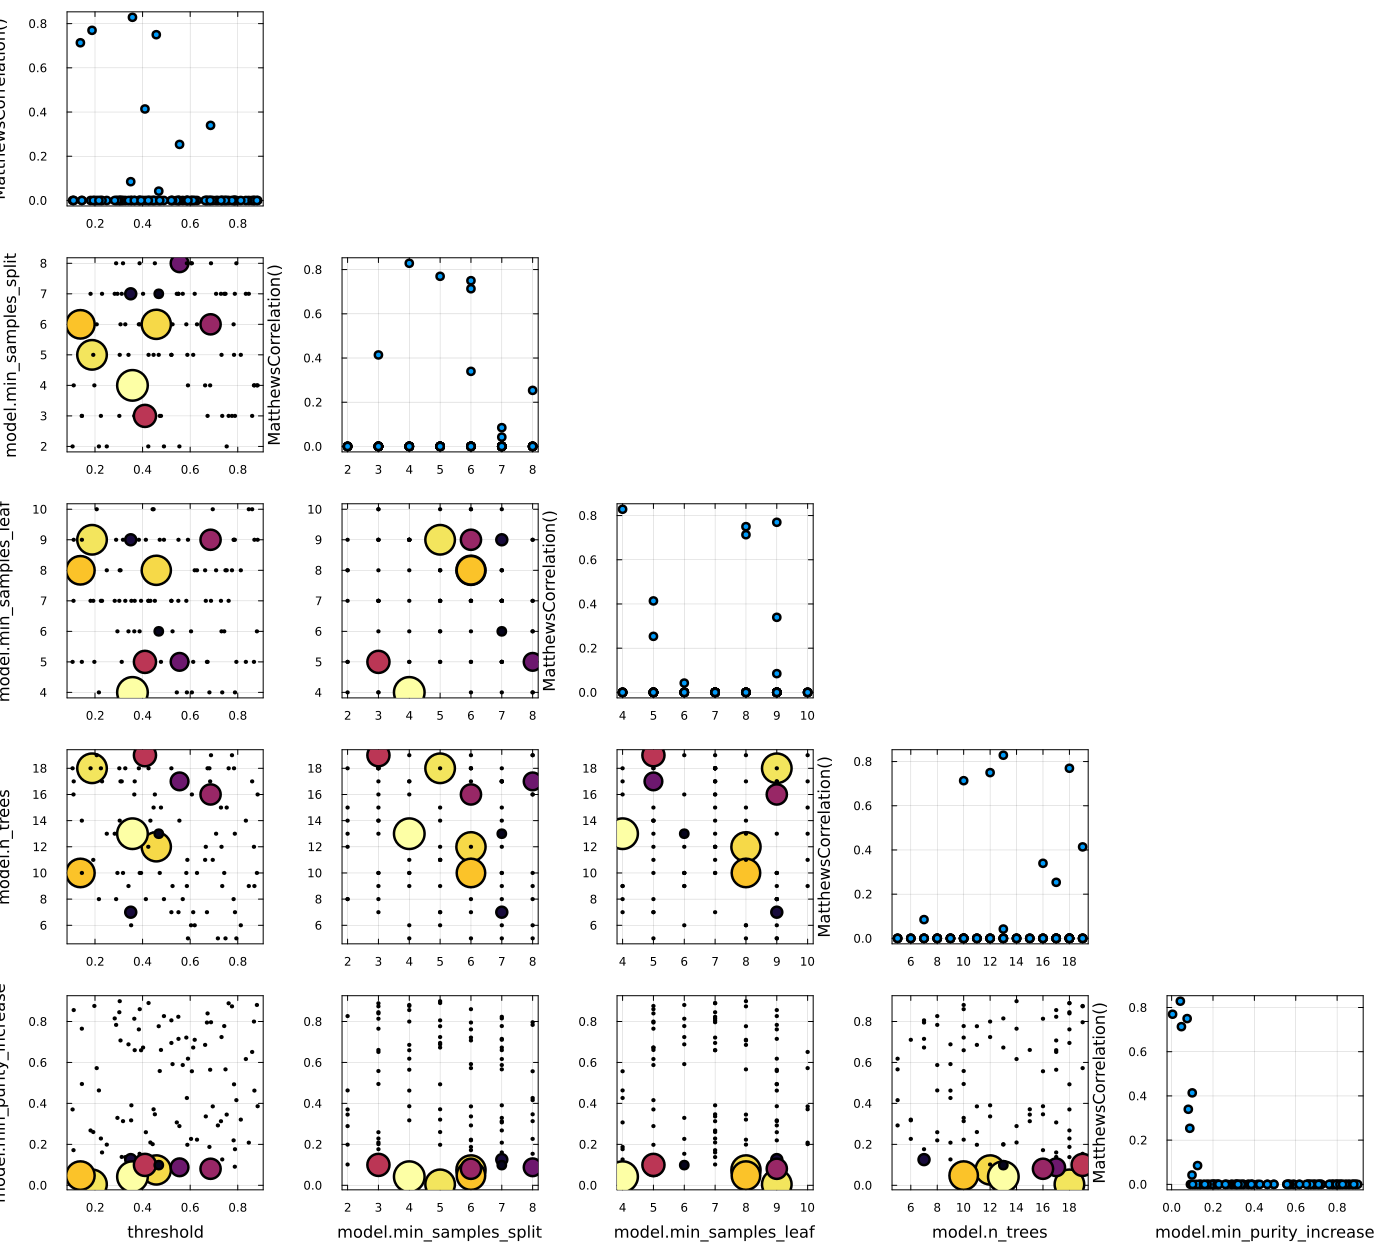

In [161]:
using Plots
plot(tuned_mach)

In [ ]:
#MLJ.feature_importances(tuned_mach.model.model.model, tuned_mach.fitresult , report(tuned_mach))
#impurity_importance(tuned_mach.model.model.model)
fitted_params(tuned_mach)[1].model

MethodError: MethodError: no method matching impurity_importance(::MLJDecisionTreeInterface.RandomForestClassifier)

Closest candidates are:
  impurity_importance(!Matched::T; normalize) where T<:DecisionTree.AdaBoostStumpClassifier
   @ DecisionTree ~/.julia/packages/DecisionTree/0Dw1P/src/scikitlearnAPI.jl:621
  impurity_importance(!Matched::T; normalize) where T<:Union{DecisionTree.AdaBoostStumpClassifier, DecisionTree.DecisionTreeClassifier, DecisionTree.DecisionTreeRegressor, DecisionTree.RandomForestClassifier, DecisionTree.RandomForestRegressor}
   @ DecisionTree ~/.julia/packages/DecisionTree/0Dw1P/src/scikitlearnAPI.jl:615
  impurity_importance(!Matched::T; kwargs...) where T<:Leaf
   @ DecisionTree ~/.julia/packages/DecisionTree/0Dw1P/src/measures.jl:451
  ...


In [154]:
m = MatthewsCorrelation()
m(mode.(y_hat), y_test)

0.8622555146940484

In [196]:
mlj_m = tuned_mach.model.model.model

RandomForestClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 100, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

In [198]:
convert(DecisionTree.RandomForestClassifier, mlj_m)

MethodError: MethodError: Cannot `convert` an object of type MLJDecisionTreeInterface.RandomForestClassifier to an object of type DecisionTree.RandomForestClassifier

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:84


In [199]:
MLJ.save("model20250407.jls", tuned_mach)